## Supervised Spot Counting using a Random Forest Classifier

### Breakdown of problem:

1. We choose our images for our data set to perform the analysis on
2. We create masks for these images
3. We segment different cells in these images
4. Label pixels in images
4. We apply an edge detection filter to identify small and big spots in cells
5. We feed these filters into our Random Forest Classifier to identify our images
5. We measure different properties of these spots
6. We apply the methods implemented above to run on our entire dataset

In [4]:
import os
import napari
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import skimage
from skimage import io, filters, img_as_ubyte, morphology
from skimage.segmentation import watershed, clear_border
from skimage.measure import regionprops, label
from skimage.exposure import adjust_gamma, rescale_intensity
from skimage.future import fit_segmenter, predict_segmenter 
from skimage.feature import multiscale_basic_features

from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from functools import partial

Here we define the location of our images. We assume the following format for each 
file in each folder: 

{initials}-{session}-{plate number}-{well location}-{site}-{wavelength}.TIF

Each label has the following format. New additions to this set much follow the same format.

{initials}-{session}-{plate number}-{well location}-{site}-labels.TIF

In [3]:
# Directories where images are stored
POLYICNO_DIR = '-condensates_11757-11758_polyICno'
POLYICYES_DIR = '+condensates_11757-11758_polyICyes'
LABELS_DIR = 'labels'
TEST_DIR = 'KRD-MOA-OC43-220310-3720-22-1_Plate_13187/TimePoint_1'

In [3]:
name = 'KRD-MOA-OC43-220310-3720-22-1_K15_s5'
dir_name = os.path.join(TEST_DIR, name+'_'+'w2'+'.TIF')
img = io.imread(dir_name)


In [4]:
# well_sites = [('KRD-MOA-OC43-220310-3720-22-1_P22_s6', TEST_DIR), \
#               ('KRD-MOA-OC43-220310-3720-22-1_P22_s5', TEST_DIR), \
#               ('KRD-MOA-OC43-220310-3720-22-1_P22_s4', TEST_DIR), \
#               ('KRD-MOA-OC43-220310-3720-22-1_P22_s3', TEST_DIR)]

# 'KRD-MOA-OC43-220310-3720-22-1_K15_s5_w1.TIF'
# 'KRD-211028-p6_G24_s3'

# wellSite = WellSite(*well_sites[0])

### WellSite Class

The following class is defined as an analog to the individual well sites.

In [65]:
# Define class for each image set belonging to a particular plate, well, and site location
class WellSite():
    def __init__(self, name, wavelength_dir, labels_dir=LABELS_DIR):
        self.wavelength_dir=wavelength_dir
        self.labels_dir=labels_dir
        self.name = name
        self.__retrieve_wavelengths()
        self.__retrieve_labels()
        self.mask = None
        
    def __retrieve_wavelengths(self):
        wavelengths = []
        for wavelength_str in ['w1', 'w2', 'w3']:
            dir_name = os.path.join(self.wavelength_dir, self.name+'_'+wavelength_str+'.TIF')
            try:
                wavelengths.append(io.imread(dir_name))
            except: 
                print("File with given plate/well/site/directory does not exist.")
        self.wavelengths = wavelengths
        
    def __retrieve_labels(self):
        file_name = self.name+'_labels.TIF'
        dir_name = os.path.join(self.labels_dir, file_name)
        labels = None
        try:
            labels = io.imread(dir_name)
        except: 
            pass
        self.labels = labels 
    
    def __create_nuclei_mask(self):
        # apply thresholding to find nuclei. threshold_otsu 
        # was chosen through experimentation
        thresh = filters.threshold_otsu(self.wavelengths[0])
        mask = self.wavelengths[0] > thresh

        # remove holes and small objects
        mask = morphology.remove_small_holes(mask)
        mask = morphology.remove_small_objects(mask, min_size=2000)

        self.nuclei_mask = mask

    def __create_cell_mask(self):
        # apply thresholding to find cytoplasm. threshold_triangle
        # was chosen through experimentation.
        thresh = filters.threshold_triangle(self.wavelengths[2])
        mask = self.wavelengths[2] > thresh

        # remove holes and small objects. Use a greater minimum size when
        # removing holes.
        mask = morphology.remove_small_holes(mask)
        mask = morphology.remove_small_objects(mask, min_size=3000)

        self.cell_mask = mask
    
    def __get_num_cells_with_condensates(self, mask, labels):
        rprops = regionprops(mask)
        label_nums = [rprop.label for rprop in rprops]
        cells_with_condensates = 0

        for label_num in label_nums:
            individual_cell_mask = (mask == label_num)
            rprops = regionprops(label((labels > 1) * individual_cell_mask))

            if len(rprops) > 0:
                cells_with_condensates += 1

        return cells_with_condensates

    # Returns a dictionary containing properties on the prediction
    def get_properties(self, labels):
        if self.mask is None:
            self.create_mask()

        props = {}

        # Constants
        UM_PER_PIXEL = 0.1747

        # skimage regionprops object list
        condensate_mask = (labels > 1) * self.mask
        labeled_condensate_mask = label(condensate_mask)
        rprops = regionprops(labeled_condensate_mask, intensity_image=self.wavelengths[1])
      
        # Define properties
        well_site = self.name
        num_cells = len(regionprops(self.mask))
        num_cells_with_condensates = self.__get_num_cells_with_condensates(self.mask, labels)
        num_condensates = len(rprops)
        num_condensates_per_cell = None
        if num_cells_with_condensates > 0:
            num_condensates_per_cell = np.around(num_condensates / num_cells_with_condensates, 2)
        
        avg_condensate_area = None
        if num_condensates > 0:
            avg_condensate_area = np.around(
                sum([prop.area for prop in rprops]) / num_condensates * UM_PER_PIXEL, 3)
            
        avg_condensate_intensity = None
        if num_condensates > 0:
            avg_condensate_intensity = np.around(
                (sum([prop.intensity_mean for prop in rprops]) / num_condensates) / 65535, 3)

        props['well_site'] = well_site
        props['num_cells'] = num_cells
        props['num_cells_with_condensates'] = num_cells_with_condensates
        props['num_condensates'] = num_condensates
        props['avg_condensates_per_cell'] = num_condensates_per_cell
        props['avg_condensate_area'] = avg_condensate_area
        props['avg_condensate_intensity'] = avg_condensate_intensity

        return props
    
    def display_wavelengths(self):
        wavelengths = self.wavelengths
        fig, axs = plt.subplots(1, len(wavelengths), figsize=(20, 25))
        for i in range(len(wavelengths)):
            img = adjust_gamma(wavelengths[i], 0.1)
            axs[i].set_title(self.name + '_w'+str(i+1))
            axs[i].imshow(img)
        fig.tight_layout()
        plt.show()
    
    def display_labels(self, labels, xlim=None, ylim=None):
        wavelengths = self.wavelengths
        
        fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(10, 15))
        ax.imshow(adjust_gamma(wavelengths[1], 0.1))
        ax.contourf(labels, alpha=0.5)
        ax.set_title('Labels for'+self.name)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        fig.tight_layout()
        
    def generate_features(self, sigma_min=1, sigma_max=10, display_features=False):
        if self.mask is None:
            self.create_mask()
            
        wavelengths = [self.wavelengths[1]]
        features_func = partial(multiscale_basic_features,
                            intensity=True, edges=False, texture=False,
                            sigma_min=sigma_min, sigma_max=sigma_max)
        features = np.concatenate([features_func(wavelength) for wavelength in wavelengths], axis=2)
        
        return features

    def create_mask(self, show_process=False):
        wavelengths = self.wavelengths

        # Use only wavelengths 1 and 3 for the creation of a mask
        nuclei_image = wavelengths[0]
        cell_mask_image = wavelengths[2]

        # create cell (cytoplasm) and nuclei masks
        nuclei_mask = self.__create_nuclei_mask()
        cell_mask = self.__create_cell_mask()
        combined_mask = self.cell_mask ^ self.nuclei_mask

        # Segment cells using nuclei as labels
        nuclei = skimage.measure.label(self.nuclei_mask)
        segments_watershed = watershed(~self.cell_mask, nuclei, mask=self.cell_mask, watershed_line=True)

        # Clear borders; remove cells that are cut off by the border
        self.mask = clear_border(segments_watershed)
        self.pre_mask = np.copy(self.mask)
        
        # Determines regions (cells) that overlap with bright spots in the image
        mean = np.mean(wavelengths[1])
        std = np.std(wavelengths[1])
        self.outlier_mask = wavelengths[1] > mean + 5 * std
        self.outlier_mask = morphology.binary_opening(self.outlier_mask, morphology.disk(15))
        
        regions_to_remove = set((self.mask * self.outlier_mask).flatten())
        
        # Remove regions
        for label in regions_to_remove:
            if label != 0:
                self.mask = self.mask * (self.mask != label)
        
        # Plot individual steps for illustration purposes
        if show_process:  
            fig, axs = plt.subplots(3, 2, figsize=(15, 15)) 
            axs = axs.ravel()
            axs[0].imshow(img_as_ubyte(adjust_gamma(wavelengths[0], 0.1)))
            axs[0].set_title('Wavelength 1')
            axs[1].imshow(img_as_ubyte(adjust_gamma(wavelengths[2], 0.1)))
            axs[1].set_title('Wavelength 3')
            axs[2].imshow(img_as_ubyte(self.nuclei_mask))
            axs[2].set_title('Nuclei Mask')
            axs[3].imshow(img_as_ubyte(self.cell_mask))
            axs[3].set_title('Cell Mask')
            axs[4].imshow(img_as_ubyte(segments_watershed - img_as_ubyte(self.nuclei_mask)))
            axs[4].set_title('Segmentation of Cells (with nuclei for clarity)')
            axs[5].imshow(img_as_ubyte(self.mask))
            axs[5].set_title('Resulting Mask (borders cleared)')
            plt.tight_layout()
            plt.show()
        

Here we use the two methods from above to create the masks themselves. After identifying cells using a watershed algorithm, we remove those that are cut off by a border. Plots of this process applied to a single well are shown. The results are satisfactory, despite the suboptimal separation of cells. This part is done mainly to identify cells that are cut off from the edges of the image. In terms of calculating the average number of spots per cell, the separations do not contribute error to this figure.

Predicting labels for: KRD-211028-p5_F24_s2
[0.00369554 0.00375778 0.00378458 0.00375615]


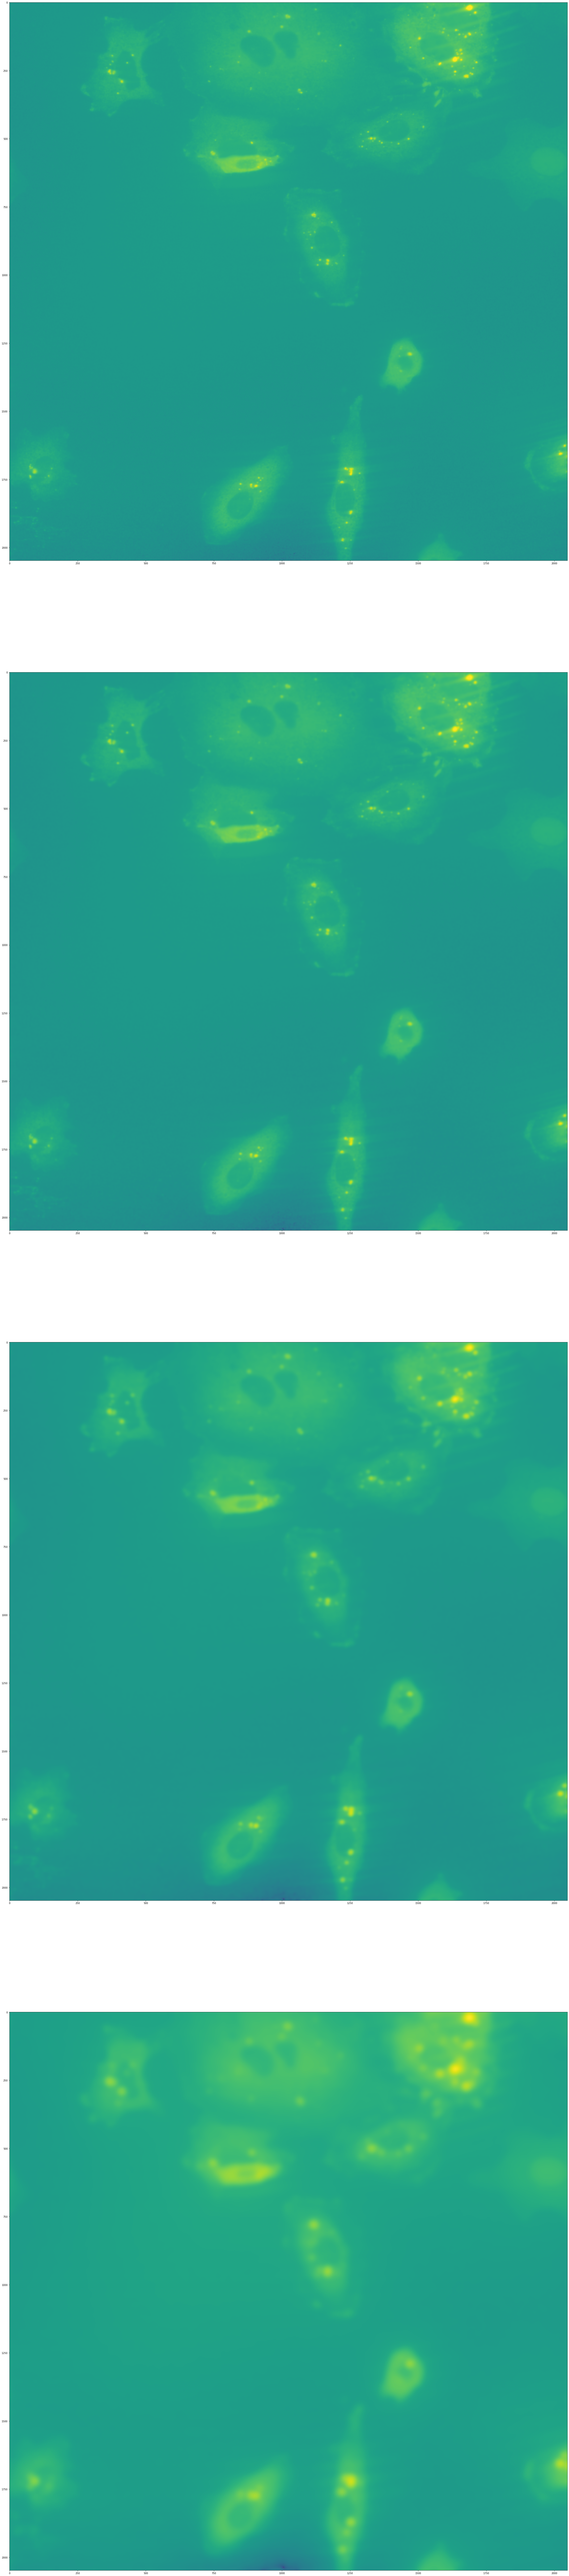

ValueError: X has 4 features, but RandomForestClassifier is expecting 12 features as input.

In [63]:
# This snippet is for running measurement on a single well site and visualizing the process
bright_well_site = ('KRD-211028-p5_F24_s2', POLYICYES_DIR)
wellSite = WellSite(*bright_well_site)

print('Predicting labels for: '+wellSite.name)
start = time.time()
pred_labels = predict_segmenter(wellSite.generate_features(display_features=True), clf)
end = time.time()
print('Completed. Time elapsed: '+str(np.around(end - start, 2))+'s')
props = wellSite.get_properties(pred_labels)
print('Properties:')
for key in props:
    print('    '+str(key)+': '+str(props[key]))

# viewer = napari.Viewer()
# # viewer.add_image(wellSite.wavelengths[0])
# viewer.add_image(wellSite.wavelengths[1])
# # viewer.add_image(wellSite.wavelengths[2])
# viewer.add_image(wellSite.mask)
# viewer.add_image(wellSite.pre_mask)
# viewer.add_image(wellSite.outlier_mask)
# viewer.add_image(pred_labels)
# viewer.show()

### Step 1: Use Napari to label images. 
This git repository includes a set of labels.

In [ ]:
# Use napari as image viewer. 
# e.g.,

# wellSite = WellSite('KRD-MOA-OC43-220310-3720-22-1_I05_s3', TEST_DIR)
# napari.view_image(wellSite.wavelengths[1])

### Step 2: Train and test Random Forest Classifier model labeled well sites
Here we use our labeled images and break up the set into training and testing data.


In [66]:
# Divide labeled data into training and testing set
labeled_well_sites = [
                      ('KRD-MOA-OC43-220310-3720-22-1_A07_s2', TEST_DIR), \
                      ('KRD-211028-p6_G24_s3', POLYICYES_DIR), \
                      ('KRD-211028-p6_G24_s4', POLYICYES_DIR), \
                      ('KRD-211028-p6_K24_s4', POLYICYES_DIR), \
                      ('KRD-211028-p6_K24_s6', POLYICYES_DIR), \
                      ]
train_set = labeled_well_sites[2:]
test_set = labeled_well_sites[:2]

# Define a classifier
# clf = RandomForestClassifier(n_estimators=40, n_jobs=-1, max_depth=40, max_samples=0.05)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, warm_start=True)


# Train on training labeled well sites
print("## Training ##")
for args in train_set:
    wellSite = WellSite(*args)
    print('\nTraining on labels for: '+wellSite.name)
    start = time.time()
    clf.set_params(n_estimators=clf.n_estimators + 30)
    clf = fit_segmenter(wellSite.labels, wellSite.generate_features(), clf)
    end = time.time()
    print('Completed. Time elapsed: '+str(np.around(end - start, 2))+'s')
    


## Training ##

Training on labels for: KRD-211028-p6_G24_s4
[0.00826571 0.00795935 0.00791025 0.0081937 ]
Completed. Time elapsed: 3.12s

Training on labels for: KRD-211028-p6_K24_s4
[0.00306704 0.00310189 0.00313426 0.00319236]
Completed. Time elapsed: 3.07s

Training on labels for: KRD-211028-p6_K24_s6
[0.00977767 0.00979175 0.00937295 0.00848125]
Completed. Time elapsed: 3.19s


In [67]:
# Test accuracy on testing labeled well sites
print("\n## Test ##")
for args in test_set:
    test_wellSite = WellSite(*args)
    print('\nPredicting labels for: '+test_wellSite.name)
    start = time.time()
    pred_labels = predict_segmenter(test_wellSite.generate_features(), clf)
    end = time.time()
    print('Completed. Time elapsed: '+str(np.around(end - start, 2))+'s')
    
    zipped = zip(pred_labels.flatten(), test_wellSite.labels.flatten())
    new_zipped = [(x, y) for x, y in zipped if y != 0]
    y_pred, y_true = zip(*new_zipped)
    print('    Accuracy score: '+str(np.around(accuracy_score(y_true, y_pred), 2)))
    print('    Balanced accuracy score: '+str(np.around(balanced_accuracy_score(y_true, y_pred), 2)))
    print(set(y_pred), set(y_true))
    props = test_wellSite.get_properties(pred_labels)
    print('Properties:')
    for key in props:
        print('    '+str(key)+': '+str(props[key]))


## Test ##

Predicting labels for: KRD-MOA-OC43-220310-3720-22-1_A07_s2
[0.00204446 0.00205301 0.00211695 0.00223481]
Completed. Time elapsed: 6.23s
    Accuracy score: 0.95
    Balanced accuracy score: 0.95
{1, 2} {1}


/Users/rodney/.virtualenvs/cs91r/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Properties:
    well_site: KRD-MOA-OC43-220310-3720-22-1_A07_s2
    num_cells: 9
    num_cells_with_condensates: 0
    num_condensates: 0
    avg_condensates_per_cell: None
    avg_condensate_area: None
    avg_condensate_intensity: None

Predicting labels for: KRD-211028-p6_G24_s3
[0.00334672 0.00340596 0.00350328 0.00356509]
Completed. Time elapsed: 6.24s
    Accuracy score: 0.98
    Balanced accuracy score: 0.96
{1, 2} {1, 2}
Properties:
    well_site: KRD-211028-p6_G24_s3
    num_cells: 15
    num_cells_with_condensates: 12
    num_condensates: 60
    avg_condensates_per_cell: 5.0
    avg_condensate_area: 3.887
    avg_condensate_intensity: 0.113


### Step 3: Use model to make predictions on some unlabeled well sites

In [5]:
import pandas as pd
import datetime

unlabeled_well_sites = sorted(list(set([(s[:-7], TEST_DIR) for s in os.listdir(TEST_DIR)])))[1:]

csv_file_name = datetime.datetime.fromtimestamp(time.time()).isoformat()+'_results.csv'

df = pd.DataFrame()
for i in range(len(unlabeled_well_sites)):
    wellSite = WellSite(*unlabeled_well_sites[i])
    print('\n'+str(i)+'/'+str(len(unlabeled_well_sites)))
    print('Predicting labels for: '+wellSite.name)
    start = time.time()
    pred_labels = predict_segmenter(wellSite.generate_features(), clf)
    end = time.time()
    print('Completed. Time elapsed: '+str(np.around(end - start, 2))+'s')
    props = wellSite.get_properties(pred_labels)
    df = pd.concat((df, pd.DataFrame([props])))
    df.to_csv(csv_file_name) 


0/2112
Predicting labels for: KRD-MOA-OC43-220310-3720-22-1_A01_s1
(2048, 2048, 12)


NameError: name 'clf' is not defined

In [ ]:
# This snippet turns a csv into a cleaned nice per-well data summary
data = pd.read_csv('polyicyes_sites.csv').values

squashed_data = np.zeros((len(data), 6), dtype=('O'))

well = None
i = -1

avg_area = 0
avg_intensity = 0

for d in data:
    if d[1][:-3] != well:
        i += 1
        well = d[1][:-3]
        squashed_data[i][0] = well # name of well
        
    squashed_data[i][1] += d[2] # number of cells
    squashed_data[i][2] += d[3] # number of cells with condensates
    squashed_data[i][3] += d[4] # number of condensates
    
    if not np.isnan(d[6]):
        squashed_data[i][4] += d[6] * d[4] # sum of condensate areas
    if not np.isnan(d[7]):
        squashed_data[i][5] += d[7] * d[4] # sum of condensate intensity
    
squashed_data = [row for row in squashed_data if np.any(row)]
for row in squashed_data:
    if row[3] != 0:
        row[4] = np.around(row[4] / row[3], 3)
        row[5] = np.around(row[5] / row[3], 3)

# row[0]: Well Name
# row[1]: Number of Cells
# row[2]: Number of Cells with Condensates
# row[3]: Number of Condensates
# row[4]: Average Condensate Area
# row[5]: Average Condensate Intensity
for row in squashed_data:
    print(row)
    
df = pd.DataFrame(squashed_data, columns=['well', 'num_cells', 'num_cells_with_condensates', 'num_condensates', 'avg_condensate_area', 'avg_condensate_intensity'])

print(df)

df.to_csv('polyicyes.csv')

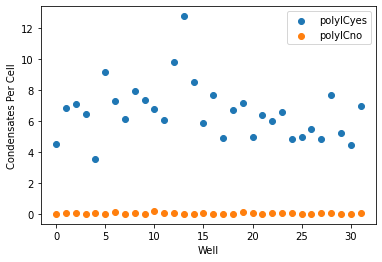

In [5]:
polyicyes_data = pd.read_csv('polyicyes.csv').values
polyicyes_avgs = np.divide(polyicyes_data[:,4],polyicyes_data[:,2])
polyicno_avgs = np.array([float(np.around(e, 2)) for e in polyicyes_avgs], dtype=(float))

polyicno_data = pd.read_csv('polyicno.csv').values
polyicno_avgs = np.divide(polyicno_data[:,4],polyicno_data[:,2])
polyicno_avgs = np.array([float(np.around(e, 2)) for e in polyicno_avgs], dtype=(float))

plt.scatter(polyicyes_data[:, 0], polyicyes_avgs, label='polyICyes')
plt.scatter(polyicyes_data[:, 0], polyicno_avgs, label='polyICno')
plt.ylabel('Condensates Per Cell')
plt.xlabel('Well')
plt.legend()